In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 o7ee3ga8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-o7ee3ga8:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.0


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                    | 1/2934 [00:00<28:51,  1.69it/s]

  0%|▎                                                                                                                                                   | 6/2934 [00:00<04:31, 10.78it/s]

  0%|▌                                                                                                                                                  | 11/2934 [00:00<02:33, 19.03it/s]

  1%|▊                                                                                                                                                  | 16/2934 [00:00<01:52, 25.90it/s]

  1%|█                                                                                                                                                  | 21/2934 [00:01<01:31, 31.75it/s]

  1%|█▎                                                                                                                                                 | 26/2934 [00:01<01:20, 36.24it/s]

  1%|█▌                                                                                                                                                 | 31/2934 [00:01<01:12, 39.78it/s]

  1%|█▊                                                                                                                                                 | 36/2934 [00:01<01:08, 42.48it/s]

  1%|██                                                                                                                                                 | 41/2934 [00:01<01:05, 44.50it/s]

  2%|██▎                                                                                                                                                | 46/2934 [00:01<01:02, 45.95it/s]

  2%|██▌                                                                                                                                                | 51/2934 [00:01<01:01, 47.03it/s]

  2%|██▊                                                                                                                                                | 56/2934 [00:01<01:00, 47.70it/s]

  2%|███                                                                                                                                                | 61/2934 [00:01<00:59, 48.22it/s]

  2%|███▎                                                                                                                                               | 66/2934 [00:01<00:59, 48.59it/s]

  2%|███▌                                                                                                                                               | 71/2934 [00:02<00:59, 48.51it/s]

  3%|███▊                                                                                                                                               | 76/2934 [00:02<00:58, 48.78it/s]

  3%|████                                                                                                                                               | 81/2934 [00:02<00:58, 48.99it/s]

  3%|████▎                                                                                                                                              | 86/2934 [00:02<00:57, 49.13it/s]

  3%|████▌                                                                                                                                              | 91/2934 [00:02<00:57, 49.26it/s]

  3%|████▊                                                                                                                                              | 96/2934 [00:02<00:57, 49.34it/s]

  3%|█████                                                                                                                                             | 101/2934 [00:02<00:57, 49.41it/s]

  4%|█████▎                                                                                                                                            | 106/2934 [00:02<00:57, 49.47it/s]

  4%|█████▌                                                                                                                                            | 111/2934 [00:02<00:57, 49.52it/s]

  4%|█████▊                                                                                                                                            | 116/2934 [00:02<00:56, 49.45it/s]

  4%|██████                                                                                                                                            | 121/2934 [00:03<00:56, 49.49it/s]

  4%|██████▎                                                                                                                                           | 126/2934 [00:03<00:56, 49.55it/s]

  4%|██████▌                                                                                                                                           | 131/2934 [00:03<00:56, 49.57it/s]

  5%|██████▊                                                                                                                                           | 136/2934 [00:03<00:56, 49.59it/s]

  5%|███████                                                                                                                                           | 141/2934 [00:03<00:56, 49.61it/s]

  5%|███████▎                                                                                                                                          | 146/2934 [00:03<00:56, 49.64it/s]

  5%|███████▌                                                                                                                                          | 151/2934 [00:03<00:56, 49.66it/s]

  5%|███████▊                                                                                                                                          | 156/2934 [00:03<00:55, 49.64it/s]

  5%|████████                                                                                                                                          | 161/2934 [00:03<00:55, 49.65it/s]

  6%|████████▎                                                                                                                                         | 166/2934 [00:03<00:55, 49.64it/s]

  6%|████████▌                                                                                                                                         | 171/2934 [00:04<00:55, 49.53it/s]

  6%|████████▊                                                                                                                                         | 176/2934 [00:04<00:55, 49.51it/s]

  6%|█████████                                                                                                                                         | 181/2934 [00:04<00:55, 49.54it/s]

  6%|█████████▎                                                                                                                                        | 186/2934 [00:04<00:55, 49.57it/s]

  7%|█████████▌                                                                                                                                        | 191/2934 [00:04<00:55, 49.61it/s]

  7%|█████████▊                                                                                                                                        | 196/2934 [00:04<00:55, 49.58it/s]

  7%|██████████                                                                                                                                        | 201/2934 [00:04<00:55, 49.57it/s]

  7%|██████████▎                                                                                                                                       | 206/2934 [00:04<00:55, 49.57it/s]

  7%|██████████▍                                                                                                                                       | 211/2934 [00:04<00:54, 49.57it/s]

  7%|██████████▋                                                                                                                                       | 216/2934 [00:04<00:54, 49.56it/s]

  8%|██████████▉                                                                                                                                       | 221/2934 [00:05<00:54, 49.50it/s]

  8%|███████████▏                                                                                                                                      | 226/2934 [00:05<00:54, 49.53it/s]

  8%|███████████▍                                                                                                                                      | 231/2934 [00:05<00:54, 49.42it/s]

  8%|███████████▋                                                                                                                                      | 236/2934 [00:05<00:54, 49.49it/s]

  8%|███████████▉                                                                                                                                      | 241/2934 [00:05<00:54, 49.53it/s]

  8%|████████████▏                                                                                                                                     | 246/2934 [00:05<00:54, 49.57it/s]

  9%|████████████▍                                                                                                                                     | 251/2934 [00:05<00:54, 49.67it/s]

  9%|████████████▋                                                                                                                                     | 256/2934 [00:05<00:53, 49.69it/s]

  9%|████████████▉                                                                                                                                     | 261/2934 [00:05<00:53, 49.65it/s]

  9%|█████████████▏                                                                                                                                    | 266/2934 [00:05<00:53, 49.65it/s]

  9%|█████████████▍                                                                                                                                    | 271/2934 [00:06<00:53, 49.63it/s]

  9%|█████████████▋                                                                                                                                    | 276/2934 [00:06<00:53, 49.61it/s]

 10%|█████████████▉                                                                                                                                    | 281/2934 [00:06<00:53, 49.56it/s]

 10%|██████████████▏                                                                                                                                   | 286/2934 [00:06<00:53, 49.46it/s]

 10%|██████████████▍                                                                                                                                   | 291/2934 [00:06<00:53, 49.49it/s]

 10%|██████████████▋                                                                                                                                   | 296/2934 [00:06<00:53, 49.55it/s]

 10%|██████████████▉                                                                                                                                   | 301/2934 [00:06<00:53, 49.61it/s]

 10%|███████████████▏                                                                                                                                  | 306/2934 [00:06<00:52, 49.63it/s]

 11%|███████████████▍                                                                                                                                  | 311/2934 [00:06<00:52, 49.62it/s]

 11%|███████████████▋                                                                                                                                  | 316/2934 [00:06<00:52, 49.64it/s]

 11%|████████████████                                                                                                                                  | 322/2934 [00:07<00:52, 49.90it/s]

 11%|████████████████▎                                                                                                                                 | 327/2934 [00:07<00:52, 49.81it/s]

 11%|████████████████▌                                                                                                                                 | 332/2934 [00:07<00:52, 49.75it/s]

 11%|████████████████▊                                                                                                                                 | 337/2934 [00:07<00:52, 49.62it/s]

 12%|█████████████████                                                                                                                                 | 342/2934 [00:07<00:52, 49.65it/s]

 12%|█████████████████▎                                                                                                                                | 347/2934 [00:07<00:52, 49.65it/s]

 12%|█████████████████▌                                                                                                                                | 352/2934 [00:07<00:51, 49.67it/s]

 12%|█████████████████▊                                                                                                                                | 357/2934 [00:07<00:51, 49.64it/s]

 12%|██████████████████                                                                                                                                | 363/2934 [00:07<00:51, 49.82it/s]

 13%|██████████████████▎                                                                                                                               | 368/2934 [00:08<00:51, 49.79it/s]

 13%|██████████████████▌                                                                                                                               | 373/2934 [00:08<00:51, 49.77it/s]

 13%|██████████████████▊                                                                                                                               | 378/2934 [00:08<00:51, 49.74it/s]

 13%|███████████████████                                                                                                                               | 383/2934 [00:08<00:51, 49.59it/s]

 13%|███████████████████▎                                                                                                                              | 388/2934 [00:08<00:51, 49.60it/s]

 13%|███████████████████▌                                                                                                                              | 393/2934 [00:08<00:51, 49.65it/s]

 14%|███████████████████▊                                                                                                                              | 398/2934 [00:08<00:51, 49.67it/s]

 14%|████████████████████                                                                                                                              | 403/2934 [00:08<00:50, 49.67it/s]

 14%|████████████████████▎                                                                                                                             | 409/2934 [00:08<00:50, 49.85it/s]

 14%|████████████████████▌                                                                                                                             | 414/2934 [00:08<00:50, 49.79it/s]

 14%|████████████████████▊                                                                                                                             | 419/2934 [00:09<00:50, 49.76it/s]

 14%|█████████████████████                                                                                                                             | 424/2934 [00:09<00:50, 49.63it/s]

 15%|█████████████████████▎                                                                                                                            | 429/2934 [00:09<00:50, 49.63it/s]

 15%|█████████████████████▌                                                                                                                            | 434/2934 [00:09<00:50, 49.64it/s]

 15%|█████████████████████▊                                                                                                                            | 439/2934 [00:09<00:50, 49.65it/s]

 15%|██████████████████████                                                                                                                            | 444/2934 [00:09<00:50, 49.64it/s]

 15%|██████████████████████▎                                                                                                                           | 449/2934 [00:09<00:50, 49.65it/s]

 15%|██████████████████████▌                                                                                                                           | 454/2934 [00:09<00:49, 49.70it/s]

 16%|██████████████████████▊                                                                                                                           | 459/2934 [00:09<00:49, 49.72it/s]

 16%|███████████████████████                                                                                                                           | 464/2934 [00:09<00:49, 49.68it/s]

 16%|███████████████████████▎                                                                                                                          | 469/2934 [00:10<00:49, 49.70it/s]

 16%|███████████████████████▌                                                                                                                          | 474/2934 [00:10<00:49, 49.67it/s]

 16%|███████████████████████▊                                                                                                                          | 479/2934 [00:10<00:49, 49.65it/s]

 16%|████████████████████████                                                                                                                          | 484/2934 [00:10<00:49, 49.55it/s]

 17%|████████████████████████▎                                                                                                                         | 489/2934 [00:10<00:49, 49.54it/s]

 17%|████████████████████████▌                                                                                                                         | 494/2934 [00:10<00:49, 49.56it/s]

 17%|████████████████████████▊                                                                                                                         | 499/2934 [00:10<00:49, 49.60it/s]

 17%|█████████████████████████                                                                                                                         | 504/2934 [00:10<00:48, 49.61it/s]

 17%|█████████████████████████▎                                                                                                                        | 509/2934 [00:10<00:48, 49.61it/s]

 18%|█████████████████████████▌                                                                                                                        | 514/2934 [00:10<00:48, 49.64it/s]

 18%|█████████████████████████▊                                                                                                                        | 519/2934 [00:11<00:48, 49.70it/s]

 18%|██████████████████████████                                                                                                                        | 524/2934 [00:11<00:48, 49.68it/s]

 18%|██████████████████████████▎                                                                                                                       | 529/2934 [00:11<00:48, 49.67it/s]

 18%|██████████████████████████▌                                                                                                                       | 534/2934 [00:11<00:48, 49.66it/s]

 18%|██████████████████████████▊                                                                                                                       | 539/2934 [00:11<00:48, 49.69it/s]

 19%|███████████████████████████                                                                                                                       | 544/2934 [00:11<00:48, 49.57it/s]

 19%|███████████████████████████▎                                                                                                                      | 549/2934 [00:11<00:48, 49.62it/s]

 19%|███████████████████████████▌                                                                                                                      | 554/2934 [00:11<00:47, 49.62it/s]

 19%|███████████████████████████▊                                                                                                                      | 559/2934 [00:11<00:47, 49.64it/s]

 19%|████████████████████████████                                                                                                                      | 564/2934 [00:11<00:47, 49.66it/s]

 19%|████████████████████████████▎                                                                                                                     | 569/2934 [00:12<00:47, 49.69it/s]

 20%|████████████████████████████▌                                                                                                                     | 574/2934 [00:12<00:47, 49.67it/s]

 20%|████████████████████████████▊                                                                                                                     | 580/2934 [00:12<00:47, 49.92it/s]

 20%|█████████████████████████████                                                                                                                     | 585/2934 [00:12<00:47, 49.82it/s]

 20%|█████████████████████████████▎                                                                                                                    | 590/2934 [00:12<00:47, 49.75it/s]

 20%|█████████████████████████████▌                                                                                                                    | 595/2934 [00:12<00:47, 49.61it/s]

 20%|█████████████████████████████▊                                                                                                                    | 600/2934 [00:12<00:47, 49.60it/s]

 21%|██████████████████████████████                                                                                                                    | 605/2934 [00:12<00:46, 49.63it/s]

 21%|██████████████████████████████▎                                                                                                                   | 610/2934 [00:12<00:46, 49.63it/s]

 21%|██████████████████████████████▌                                                                                                                   | 615/2934 [00:12<00:46, 49.63it/s]

 21%|██████████████████████████████▊                                                                                                                   | 620/2934 [00:13<00:46, 49.62it/s]

 21%|███████████████████████████████                                                                                                                   | 625/2934 [00:13<00:46, 49.60it/s]

 21%|███████████████████████████████▎                                                                                                                  | 630/2934 [00:13<00:46, 49.61it/s]

 22%|███████████████████████████████▌                                                                                                                  | 635/2934 [00:13<00:46, 49.60it/s]

 22%|███████████████████████████████▊                                                                                                                  | 640/2934 [00:13<00:46, 49.59it/s]

 22%|████████████████████████████████                                                                                                                  | 645/2934 [00:13<00:46, 49.59it/s]

 22%|████████████████████████████████▎                                                                                                                 | 650/2934 [00:13<00:46, 49.42it/s]

 22%|████████████████████████████████▌                                                                                                                 | 655/2934 [00:13<00:46, 49.47it/s]

 22%|████████████████████████████████▊                                                                                                                 | 660/2934 [00:13<00:45, 49.50it/s]

 23%|█████████████████████████████████                                                                                                                 | 665/2934 [00:14<00:45, 49.53it/s]

 23%|█████████████████████████████████▎                                                                                                                | 670/2934 [00:14<00:45, 49.56it/s]

 23%|█████████████████████████████████▌                                                                                                                | 675/2934 [00:14<00:45, 49.58it/s]

 23%|█████████████████████████████████▊                                                                                                                | 680/2934 [00:14<00:45, 49.60it/s]

 23%|██████████████████████████████████                                                                                                                | 685/2934 [00:14<00:45, 49.62it/s]

 24%|██████████████████████████████████▎                                                                                                               | 690/2934 [00:14<00:45, 49.58it/s]

 24%|██████████████████████████████████▌                                                                                                               | 695/2934 [00:14<00:45, 49.59it/s]

 24%|██████████████████████████████████▊                                                                                                               | 700/2934 [00:14<00:45, 49.60it/s]

 24%|███████████████████████████████████                                                                                                               | 705/2934 [00:14<00:44, 49.57it/s]

 24%|███████████████████████████████████▍                                                                                                              | 711/2934 [00:14<00:44, 49.79it/s]

 24%|███████████████████████████████████▋                                                                                                              | 717/2934 [00:15<00:44, 49.92it/s]

 25%|███████████████████████████████████▉                                                                                                              | 723/2934 [00:15<00:44, 50.01it/s]

 25%|████████████████████████████████████▏                                                                                                             | 728/2934 [00:15<00:44, 49.94it/s]

 25%|████████████████████████████████████▌                                                                                                             | 734/2934 [00:15<00:43, 50.14it/s]

 25%|████████████████████████████████████▊                                                                                                             | 740/2934 [00:15<00:43, 50.21it/s]

 25%|█████████████████████████████████████                                                                                                             | 746/2934 [00:15<00:43, 50.25it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 752/2934 [00:15<00:43, 50.18it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 758/2934 [00:15<00:43, 50.23it/s]

 26%|██████████████████████████████████████                                                                                                            | 764/2934 [00:15<00:43, 50.29it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 770/2934 [00:16<00:43, 50.24it/s]

 26%|██████████████████████████████████████▌                                                                                                           | 776/2934 [00:16<00:42, 50.26it/s]

 27%|██████████████████████████████████████▉                                                                                                           | 782/2934 [00:16<00:42, 50.26it/s]

 27%|███████████████████████████████████████▏                                                                                                          | 788/2934 [00:16<00:42, 50.25it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 794/2934 [00:16<00:42, 50.25it/s]

 27%|███████████████████████████████████████▊                                                                                                          | 800/2934 [00:16<00:42, 50.29it/s]

 27%|████████████████████████████████████████                                                                                                          | 806/2934 [00:16<00:42, 50.29it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 812/2934 [00:16<00:42, 50.30it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 818/2934 [00:17<00:42, 50.24it/s]

 28%|█████████████████████████████████████████                                                                                                         | 824/2934 [00:17<00:41, 50.46it/s]

 28%|█████████████████████████████████████████▎                                                                                                        | 830/2934 [00:17<00:41, 50.24it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 836/2934 [00:17<00:41, 50.13it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 842/2934 [00:17<00:41, 50.13it/s]

 29%|██████████████████████████████████████████▏                                                                                                       | 848/2934 [00:17<00:41, 50.09it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 854/2934 [00:17<00:41, 50.17it/s]

 29%|██████████████████████████████████████████▊                                                                                                       | 860/2934 [00:17<00:41, 50.18it/s]

 30%|███████████████████████████████████████████                                                                                                       | 866/2934 [00:18<00:41, 50.21it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 872/2934 [00:18<00:41, 50.21it/s]

 30%|███████████████████████████████████████████▋                                                                                                      | 878/2934 [00:18<00:40, 50.30it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 884/2934 [00:18<00:40, 50.31it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 890/2934 [00:18<00:40, 50.23it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 896/2934 [00:18<00:40, 50.25it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 902/2934 [00:18<00:40, 50.30it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 908/2934 [00:18<00:40, 50.25it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 914/2934 [00:18<00:40, 50.27it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 920/2934 [00:19<00:40, 50.32it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 926/2934 [00:19<00:39, 50.29it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 932/2934 [00:19<00:39, 50.33it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 938/2934 [00:19<00:39, 50.33it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 944/2934 [00:19<00:39, 50.22it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 950/2934 [00:19<00:39, 50.26it/s]

 33%|███████████████████████████████████████████████▌                                                                                                  | 956/2934 [00:19<00:39, 50.31it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 962/2934 [00:19<00:39, 50.32it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 968/2934 [00:20<00:39, 50.26it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 974/2934 [00:20<00:38, 50.29it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 980/2934 [00:20<00:38, 50.33it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 986/2934 [00:20<00:38, 50.27it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 992/2934 [00:20<00:38, 50.31it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 998/2934 [00:20<00:38, 50.34it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 1004/2934 [00:20<00:38, 50.19it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 1010/2934 [00:20<00:38, 50.25it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 1016/2934 [00:20<00:38, 50.28it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 1022/2934 [00:21<00:38, 50.26it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 1028/2934 [00:21<00:37, 50.30it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 1034/2934 [00:21<00:37, 50.32it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 1040/2934 [00:21<00:37, 50.25it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 1046/2934 [00:21<00:37, 50.51it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 1052/2934 [00:21<00:37, 50.50it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 1058/2934 [00:21<00:37, 50.47it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 1064/2934 [00:21<00:37, 50.35it/s]

 36%|████████████████████████████████████████████████████▉                                                                                            | 1070/2934 [00:22<00:37, 50.35it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 1076/2934 [00:22<00:36, 50.38it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 1082/2934 [00:22<00:36, 50.35it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 1088/2934 [00:22<00:36, 50.36it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 1094/2934 [00:22<00:36, 50.33it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 1100/2934 [00:22<00:36, 50.23it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 1106/2934 [00:22<00:36, 50.22it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 1112/2934 [00:22<00:36, 50.27it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 1118/2934 [00:23<00:36, 50.32it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 1124/2934 [00:23<00:36, 50.22it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                         | 1130/2934 [00:23<00:35, 50.24it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 1136/2934 [00:23<00:35, 50.28it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                        | 1142/2934 [00:23<00:35, 50.21it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                        | 1148/2934 [00:23<00:35, 50.28it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 1154/2934 [00:23<00:35, 50.35it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 1160/2934 [00:23<00:35, 50.22it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 1166/2934 [00:23<00:35, 50.21it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                       | 1172/2934 [00:24<00:35, 50.27it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 1178/2934 [00:24<00:34, 50.22it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 1184/2934 [00:24<00:34, 50.28it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                      | 1190/2934 [00:24<00:34, 50.33it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 1196/2934 [00:24<00:34, 50.34it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 1202/2934 [00:24<00:34, 50.33it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 1208/2934 [00:24<00:34, 50.36it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 1214/2934 [00:24<00:34, 50.38it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 1220/2934 [00:25<00:34, 50.34it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 1226/2934 [00:25<00:33, 50.32it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 1232/2934 [00:25<00:33, 50.34it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 1238/2934 [00:25<00:33, 50.28it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                   | 1244/2934 [00:25<00:33, 50.31it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 1250/2934 [00:25<00:33, 50.34it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 1256/2934 [00:25<00:33, 50.35it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 1262/2934 [00:25<00:33, 50.27it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 1268/2934 [00:26<00:33, 50.31it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 1274/2934 [00:26<00:32, 50.36it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 1280/2934 [00:26<00:32, 50.32it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 1286/2934 [00:26<00:32, 50.30it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 1292/2934 [00:26<00:32, 50.37it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 1298/2934 [00:26<00:32, 50.27it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 1304/2934 [00:26<00:32, 50.32it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                                | 1310/2934 [00:26<00:32, 50.34it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 1316/2934 [00:26<00:32, 50.28it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 1322/2934 [00:27<00:31, 50.71it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 1328/2934 [00:27<00:31, 51.00it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 1334/2934 [00:27<00:31, 51.09it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 1340/2934 [00:27<00:31, 51.25it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 1346/2934 [00:27<00:30, 51.37it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 1352/2934 [00:27<00:30, 51.46it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 1358/2934 [00:27<00:30, 51.44it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                             | 1364/2934 [00:27<00:30, 51.50it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 1370/2934 [00:28<00:30, 51.55it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 1376/2934 [00:28<00:30, 51.49it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                            | 1382/2934 [00:28<00:30, 51.55it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                            | 1388/2934 [00:28<00:29, 51.60it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 1394/2934 [00:28<00:29, 51.52it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 1400/2934 [00:28<00:29, 51.54it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 1406/2934 [00:28<00:29, 51.56it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 1412/2934 [00:28<00:29, 51.60it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                           | 1418/2934 [00:28<00:29, 51.53it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                          | 1424/2934 [00:29<00:29, 51.56it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 1430/2934 [00:29<00:29, 51.58it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                          | 1436/2934 [00:29<00:29, 51.52it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 1442/2934 [00:29<00:28, 51.57it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 1448/2934 [00:29<00:28, 51.59it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 1454/2934 [00:29<00:28, 51.51it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 1460/2934 [00:29<00:28, 51.55it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                        | 1466/2934 [00:29<00:28, 51.60it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 1472/2934 [00:29<00:28, 51.51it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 1478/2934 [00:30<00:28, 51.44it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 1484/2934 [00:30<00:28, 51.49it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 1490/2934 [00:30<00:28, 51.44it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 1496/2934 [00:30<00:27, 51.49it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 1502/2934 [00:30<00:27, 51.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 1508/2934 [00:30<00:27, 51.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 1514/2934 [00:30<00:27, 51.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                      | 1520/2934 [00:30<00:27, 51.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 1526/2934 [00:31<00:27, 51.56it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 1532/2934 [00:31<00:27, 51.49it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                     | 1538/2934 [00:31<00:27, 51.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 1544/2934 [00:31<00:26, 51.57it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 1550/2934 [00:31<00:26, 51.49it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 1556/2934 [00:31<00:26, 51.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 1562/2934 [00:31<00:26, 51.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 1568/2934 [00:31<00:26, 51.50it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 1574/2934 [00:31<00:26, 51.55it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                   | 1580/2934 [00:32<00:26, 51.57it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                  | 1586/2934 [00:32<00:26, 51.28it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 1592/2934 [00:32<00:26, 50.86it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 1598/2934 [00:32<00:26, 50.68it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 1604/2934 [00:32<00:26, 50.59it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 1610/2934 [00:32<00:26, 50.48it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 1616/2934 [00:32<00:26, 50.43it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 1622/2934 [00:32<00:26, 50.44it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 1628/2934 [00:33<00:25, 50.39it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 1634/2934 [00:33<00:25, 50.42it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                | 1640/2934 [00:33<00:25, 50.44it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 1646/2934 [00:33<00:25, 50.43it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 1652/2934 [00:33<00:25, 50.35it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                               | 1658/2934 [00:33<00:25, 50.33it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 1664/2934 [00:33<00:25, 50.14it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 1670/2934 [00:33<00:25, 50.24it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 1676/2934 [00:33<00:25, 50.29it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 1682/2934 [00:34<00:24, 50.26it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 1688/2934 [00:34<00:24, 50.33it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 1694/2934 [00:34<00:24, 50.36it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 1700/2934 [00:34<00:24, 50.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1706/2934 [00:34<00:24, 50.33it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1712/2934 [00:34<00:24, 50.26it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1718/2934 [00:34<00:24, 50.26it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1724/2934 [00:34<00:24, 50.24it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1730/2934 [00:35<00:23, 50.32it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1736/2934 [00:35<00:23, 50.37it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 1742/2934 [00:35<00:23, 50.31it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1748/2934 [00:35<00:23, 50.31it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1754/2934 [00:35<00:23, 50.35it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1760/2934 [00:35<00:23, 50.38it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1766/2934 [00:35<00:23, 50.34it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1772/2934 [00:35<00:23, 50.37it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1778/2934 [00:36<00:22, 50.40it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1784/2934 [00:36<00:22, 50.27it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1790/2934 [00:36<00:22, 50.27it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1796/2934 [00:36<00:22, 50.28it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                        | 1802/2934 [00:36<00:22, 50.23it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1808/2934 [00:36<00:22, 50.29it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1814/2934 [00:36<00:22, 50.36it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1820/2934 [00:36<00:22, 50.20it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1826/2934 [00:36<00:22, 50.20it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1832/2934 [00:37<00:21, 50.29it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1838/2934 [00:37<00:21, 50.32it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1844/2934 [00:37<00:21, 50.31it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1850/2934 [00:37<00:21, 50.18it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1856/2934 [00:37<00:21, 50.10it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1862/2934 [00:37<00:21, 50.08it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1868/2934 [00:37<00:21, 50.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1874/2934 [00:37<00:21, 50.02it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1880/2934 [00:38<00:20, 50.24it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1886/2934 [00:38<00:20, 50.38it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1892/2934 [00:38<00:20, 50.38it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1898/2934 [00:38<00:20, 50.31it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1904/2934 [00:38<00:20, 50.34it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1910/2934 [00:38<00:20, 50.35it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1916/2934 [00:38<00:20, 50.38it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1922/2934 [00:38<00:20, 50.33it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1928/2934 [00:38<00:19, 50.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1934/2934 [00:39<00:19, 50.41it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1940/2934 [00:39<00:19, 50.34it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1946/2934 [00:39<00:19, 50.29it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1952/2934 [00:39<00:19, 50.31it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1958/2934 [00:39<00:19, 50.27it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1964/2934 [00:39<00:19, 50.28it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1970/2934 [00:39<00:19, 50.36it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1976/2934 [00:39<00:19, 50.37it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1982/2934 [00:40<00:18, 50.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1988/2934 [00:40<00:18, 50.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1994/2934 [00:40<00:18, 50.22it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2000/2934 [00:40<00:18, 50.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2006/2934 [00:40<00:18, 50.28it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2012/2934 [00:40<00:18, 50.33it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2018/2934 [00:40<00:18, 50.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2024/2934 [00:40<00:18, 50.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2030/2934 [00:41<00:17, 50.31it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2036/2934 [00:41<00:17, 50.28it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2042/2934 [00:41<00:17, 50.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2048/2934 [00:41<00:17, 50.37it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2054/2934 [00:41<00:17, 50.38it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2060/2934 [00:41<00:17, 50.10it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2066/2934 [00:41<00:17, 50.13it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2072/2934 [00:41<00:17, 50.19it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2078/2934 [00:41<00:17, 50.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2084/2934 [00:42<00:16, 50.29it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2090/2934 [00:42<00:16, 50.35it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2096/2934 [00:42<00:16, 50.25it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2102/2934 [00:42<00:16, 50.30it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2108/2934 [00:42<00:16, 50.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2114/2934 [00:42<00:16, 50.23it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2120/2934 [00:42<00:16, 50.31it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2126/2934 [00:42<00:16, 50.41it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2132/2934 [00:43<00:15, 50.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2138/2934 [00:43<00:15, 50.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2144/2934 [00:43<00:15, 50.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2150/2934 [00:43<00:15, 50.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2156/2934 [00:43<00:15, 50.32it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2162/2934 [00:43<00:15, 50.36it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2168/2934 [00:43<00:15, 50.36it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2174/2934 [00:43<00:15, 50.31it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2180/2934 [00:44<00:14, 50.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2186/2934 [00:44<00:14, 50.39it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2192/2934 [00:44<00:14, 50.33it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2198/2934 [00:44<00:14, 50.36it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2204/2934 [00:44<00:14, 50.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2210/2934 [00:44<00:14, 50.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2216/2934 [00:44<00:14, 50.22it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2222/2934 [00:44<00:14, 50.28it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2228/2934 [00:44<00:14, 50.32it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2234/2934 [00:45<00:13, 50.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2240/2934 [00:45<00:13, 50.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2246/2934 [00:45<00:13, 50.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2252/2934 [00:45<00:13, 50.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2258/2934 [00:45<00:13, 50.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2264/2934 [00:45<00:13, 50.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2270/2934 [00:45<00:13, 50.31it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2276/2934 [00:45<00:13, 50.34it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2282/2934 [00:46<00:12, 50.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2288/2934 [00:46<00:12, 50.24it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2294/2934 [00:46<00:12, 50.30it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2300/2934 [00:46<00:12, 50.33it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2306/2934 [00:46<00:12, 50.37it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2312/2934 [00:46<00:12, 50.35it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2318/2934 [00:46<00:12, 50.33it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2324/2934 [00:46<00:12, 50.30it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2330/2934 [00:46<00:12, 50.25it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2336/2934 [00:47<00:11, 50.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2342/2934 [00:47<00:11, 50.34it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2348/2934 [00:47<00:11, 50.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2354/2934 [00:47<00:11, 50.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2360/2934 [00:47<00:11, 50.27it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2366/2934 [00:47<00:11, 50.30it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2372/2934 [00:47<00:11, 49.98it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2377/2934 [00:47<00:11, 49.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2382/2934 [00:48<00:11, 49.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2387/2934 [00:48<00:11, 49.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2392/2934 [00:48<00:11, 49.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2397/2934 [00:48<00:10, 49.12it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2402/2934 [00:48<00:10, 49.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2407/2934 [00:48<00:10, 49.10it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2412/2934 [00:48<00:10, 49.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2417/2934 [00:48<00:10, 49.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2422/2934 [00:48<00:10, 49.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2427/2934 [00:48<00:10, 49.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2432/2934 [00:49<00:10, 49.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2437/2934 [00:49<00:10, 49.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2442/2934 [00:49<00:10, 49.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2447/2934 [00:49<00:09, 49.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2452/2934 [00:49<00:09, 49.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2457/2934 [00:49<00:09, 49.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2462/2934 [00:49<00:09, 49.03it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2467/2934 [00:49<00:09, 48.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2472/2934 [00:49<00:09, 48.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2477/2934 [00:49<00:09, 49.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2482/2934 [00:50<00:09, 49.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2487/2934 [00:50<00:09, 49.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2492/2934 [00:50<00:09, 49.05it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2497/2934 [00:50<00:08, 49.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2502/2934 [00:50<00:08, 49.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2507/2934 [00:50<00:08, 49.11it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2512/2934 [00:50<00:08, 49.15it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2517/2934 [00:50<00:08, 49.18it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2522/2934 [00:50<00:08, 49.19it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2527/2934 [00:50<00:08, 49.08it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2532/2934 [00:51<00:08, 49.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2537/2934 [00:51<00:08, 49.00it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2542/2934 [00:51<00:08, 49.00it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2547/2934 [00:51<00:07, 49.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2552/2934 [00:51<00:07, 48.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2557/2934 [00:51<00:07, 49.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2562/2934 [00:51<00:07, 49.08it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2567/2934 [00:51<00:07, 49.11it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2572/2934 [00:51<00:07, 49.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2577/2934 [00:52<00:07, 49.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2582/2934 [00:52<00:07, 49.15it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2587/2934 [00:52<00:07, 49.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2592/2934 [00:52<00:06, 49.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2597/2934 [00:52<00:06, 49.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2602/2934 [00:52<00:06, 49.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2607/2934 [00:52<00:06, 49.06it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2612/2934 [00:52<00:06, 49.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2617/2934 [00:52<00:06, 49.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2622/2934 [00:52<00:06, 49.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2627/2934 [00:53<00:06, 49.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2632/2934 [00:53<00:06, 49.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2637/2934 [00:53<00:06, 49.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2642/2934 [00:53<00:05, 49.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2647/2934 [00:53<00:05, 49.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2652/2934 [00:53<00:05, 49.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2657/2934 [00:53<00:05, 49.15it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2662/2934 [00:53<00:05, 49.09it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2667/2934 [00:53<00:05, 48.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2672/2934 [00:53<00:05, 48.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2677/2934 [00:54<00:05, 48.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2682/2934 [00:54<00:05, 48.96it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2687/2934 [00:54<00:05, 48.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2692/2934 [00:54<00:04, 49.02it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2697/2934 [00:54<00:04, 49.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2702/2934 [00:54<00:04, 49.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2707/2934 [00:54<00:04, 49.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2712/2934 [00:54<00:04, 49.11it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2717/2934 [00:54<00:04, 49.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2722/2934 [00:54<00:04, 49.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2727/2934 [00:55<00:04, 49.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2732/2934 [00:55<00:04, 49.24it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2737/2934 [00:55<00:04, 49.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2742/2934 [00:55<00:03, 49.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2747/2934 [00:55<00:03, 49.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2752/2934 [00:55<00:03, 49.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2757/2934 [00:55<00:03, 49.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2762/2934 [00:55<00:03, 49.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2767/2934 [00:55<00:03, 49.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2772/2934 [00:55<00:03, 49.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2777/2934 [00:56<00:03, 49.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2782/2934 [00:56<00:03, 49.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2787/2934 [00:56<00:02, 49.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2792/2934 [00:56<00:02, 49.12it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2797/2934 [00:56<00:02, 49.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2802/2934 [00:56<00:02, 49.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2807/2934 [00:56<00:02, 49.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2812/2934 [00:56<00:02, 49.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2817/2934 [00:56<00:02, 49.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2822/2934 [00:57<00:02, 49.02it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2827/2934 [00:57<00:02, 49.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2832/2934 [00:57<00:02, 48.99it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2837/2934 [00:57<00:01, 49.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2842/2934 [00:57<00:01, 49.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2847/2934 [00:57<00:01, 49.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2852/2934 [00:57<00:01, 48.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2857/2934 [00:57<00:01, 49.02it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2862/2934 [00:57<00:01, 49.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2867/2934 [00:57<00:01, 49.09it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2872/2934 [00:58<00:01, 49.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2877/2934 [00:58<00:01, 49.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2882/2934 [00:58<00:01, 49.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2887/2934 [00:58<00:00, 49.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2892/2934 [00:58<00:00, 49.03it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2897/2934 [00:58<00:00, 49.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2902/2934 [00:58<00:00, 48.99it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2907/2934 [00:58<00:00, 49.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2912/2934 [00:58<00:00, 49.03it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2917/2934 [00:58<00:00, 49.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2922/2934 [00:59<00:00, 49.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2927/2934 [00:59<00:00, 47.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [00:59<00:00, 47.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [00:59<00:00, 49.43it/s]

train - OK


  0%|                                                                                                                                                             | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/380 [00:00<01:56,  3.26it/s]

  2%|██▎                                                                                                                                                  | 6/380 [00:00<00:21, 17.59it/s]

  3%|████▎                                                                                                                                               | 11/380 [00:00<00:13, 26.96it/s]

  4%|██████▏                                                                                                                                             | 16/380 [00:00<00:10, 33.43it/s]

  6%|████████▏                                                                                                                                           | 21/380 [00:00<00:09, 37.86it/s]

  7%|██████████▏                                                                                                                                         | 26/380 [00:00<00:08, 40.90it/s]

  8%|████████████                                                                                                                                        | 31/380 [00:00<00:08, 42.78it/s]

  9%|██████████████                                                                                                                                      | 36/380 [00:01<00:07, 44.21it/s]

 11%|███████████████▉                                                                                                                                    | 41/380 [00:01<00:07, 45.32it/s]

 12%|█████████████████▉                                                                                                                                  | 46/380 [00:01<00:07, 46.11it/s]

 13%|███████████████████▊                                                                                                                                | 51/380 [00:01<00:07, 46.65it/s]

 15%|█████████████████████▊                                                                                                                              | 56/380 [00:01<00:06, 47.00it/s]

 16%|███████████████████████▊                                                                                                                            | 61/380 [00:01<00:06, 47.40it/s]

 17%|█████████████████████████▋                                                                                                                          | 66/380 [00:01<00:06, 47.86it/s]

 19%|███████████████████████████▋                                                                                                                        | 71/380 [00:01<00:06, 48.24it/s]

 20%|█████████████████████████████▌                                                                                                                      | 76/380 [00:01<00:06, 48.20it/s]

 21%|███████████████████████████████▌                                                                                                                    | 81/380 [00:01<00:06, 48.21it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 86/380 [00:02<00:06, 48.37it/s]

 24%|███████████████████████████████████▍                                                                                                                | 91/380 [00:02<00:05, 48.57it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 96/380 [00:02<00:05, 48.69it/s]

 27%|███████████████████████████████████████                                                                                                            | 101/380 [00:02<00:05, 48.37it/s]

 28%|█████████████████████████████████████████                                                                                                          | 106/380 [00:02<00:05, 48.47it/s]

 29%|██████████████████████████████████████████▉                                                                                                        | 111/380 [00:02<00:05, 48.61it/s]

 31%|████████████████████████████████████████████▊                                                                                                      | 116/380 [00:02<00:05, 48.72it/s]

 32%|██████████████████████████████████████████████▊                                                                                                    | 121/380 [00:02<00:05, 48.69it/s]

 33%|████████████████████████████████████████████████▋                                                                                                  | 126/380 [00:02<00:05, 48.41it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                | 131/380 [00:03<00:05, 48.56it/s]

 36%|████████████████████████████████████████████████████▌                                                                                              | 136/380 [00:03<00:05, 48.67it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                            | 141/380 [00:03<00:04, 48.78it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 146/380 [00:03<00:04, 48.51it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 151/380 [00:03<00:04, 48.46it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 156/380 [00:03<00:04, 48.60it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 161/380 [00:03<00:04, 48.57it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 166/380 [00:03<00:04, 48.72it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 171/380 [00:03<00:04, 48.76it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 176/380 [00:03<00:04, 48.69it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 181/380 [00:04<00:04, 48.71it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 186/380 [00:04<00:03, 48.74it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 191/380 [00:04<00:03, 48.60it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 196/380 [00:04<00:03, 48.40it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 201/380 [00:04<00:03, 48.51it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 206/380 [00:04<00:03, 48.62it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 211/380 [00:04<00:03, 48.69it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 216/380 [00:04<00:03, 48.38it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/380 [00:04<00:03, 48.44it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 226/380 [00:04<00:03, 48.56it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 231/380 [00:05<00:03, 48.63it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 236/380 [00:05<00:02, 48.63it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 241/380 [00:05<00:02, 48.41it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 246/380 [00:05<00:02, 48.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 251/380 [00:05<00:02, 48.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 256/380 [00:05<00:02, 48.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 261/380 [00:05<00:02, 48.31it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 266/380 [00:05<00:02, 48.48it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 271/380 [00:05<00:02, 48.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 276/380 [00:05<00:02, 48.72it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 281/380 [00:06<00:02, 48.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 286/380 [00:06<00:01, 48.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 291/380 [00:06<00:01, 48.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 296/380 [00:06<00:01, 48.69it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 301/380 [00:06<00:01, 48.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 306/380 [00:06<00:01, 48.50it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 311/380 [00:06<00:01, 48.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 316/380 [00:06<00:01, 48.64it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 321/380 [00:06<00:01, 48.72it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 326/380 [00:07<00:01, 48.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 331/380 [00:07<00:01, 48.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 336/380 [00:07<00:00, 48.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 341/380 [00:07<00:00, 48.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 346/380 [00:07<00:00, 48.59it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 351/380 [00:07<00:00, 48.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 356/380 [00:07<00:00, 48.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 361/380 [00:07<00:00, 48.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 366/380 [00:07<00:00, 48.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 371/380 [00:07<00:00, 48.43it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [00:08<00:00, 48.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:08<00:00, 45.98it/s]

val - OK


  0%|                                                                                                                                                             | 0/382 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/382 [00:00<02:08,  2.96it/s]

  2%|██▎                                                                                                                                                  | 6/382 [00:00<00:22, 16.50it/s]

  3%|████▎                                                                                                                                               | 11/382 [00:00<00:14, 25.95it/s]

  4%|██████▏                                                                                                                                             | 16/382 [00:00<00:11, 32.63it/s]

  5%|████████▏                                                                                                                                           | 21/382 [00:00<00:09, 37.13it/s]

  7%|██████████                                                                                                                                          | 26/382 [00:00<00:08, 40.39it/s]

  8%|████████████                                                                                                                                        | 31/382 [00:00<00:08, 42.77it/s]

  9%|█████████████▉                                                                                                                                      | 36/382 [00:01<00:07, 44.41it/s]

 11%|███████████████▉                                                                                                                                    | 41/382 [00:01<00:07, 45.55it/s]

 12%|█████████████████▊                                                                                                                                  | 46/382 [00:01<00:07, 46.37it/s]

 13%|███████████████████▊                                                                                                                                | 51/382 [00:01<00:07, 47.00it/s]

 15%|█████████████████████▋                                                                                                                              | 56/382 [00:01<00:06, 47.45it/s]

 16%|███████████████████████▋                                                                                                                            | 61/382 [00:01<00:06, 47.78it/s]

 17%|█████████████████████████▌                                                                                                                          | 66/382 [00:01<00:06, 47.78it/s]

 19%|███████████████████████████▌                                                                                                                        | 71/382 [00:01<00:06, 47.75it/s]

 20%|█████████████████████████████▍                                                                                                                      | 76/382 [00:01<00:06, 47.95it/s]

 21%|███████████████████████████████▍                                                                                                                    | 81/382 [00:02<00:06, 48.05it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 86/382 [00:02<00:06, 48.18it/s]

 24%|███████████████████████████████████▎                                                                                                                | 91/382 [00:02<00:06, 47.88it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 96/382 [00:02<00:05, 47.95it/s]

 26%|██████████████████████████████████████▊                                                                                                            | 101/382 [00:02<00:05, 48.10it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 106/382 [00:02<00:05, 48.21it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 111/382 [00:02<00:05, 48.33it/s]

 30%|████████████████████████████████████████████▋                                                                                                      | 116/382 [00:02<00:05, 48.41it/s]

 32%|██████████████████████████████████████████████▌                                                                                                    | 121/382 [00:02<00:05, 48.46it/s]

 33%|████████████████████████████████████████████████▍                                                                                                  | 126/382 [00:02<00:05, 48.52it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                | 131/382 [00:03<00:05, 48.47it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 136/382 [00:03<00:05, 48.18it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 141/382 [00:03<00:05, 48.14it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                          | 146/382 [00:03<00:04, 48.27it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 151/382 [00:03<00:04, 48.37it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 156/382 [00:03<00:04, 48.40it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 161/382 [00:03<00:04, 48.37it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 166/382 [00:03<00:04, 48.37it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 171/382 [00:03<00:04, 48.37it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 176/382 [00:03<00:04, 48.37it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 181/382 [00:04<00:04, 48.18it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 186/382 [00:04<00:04, 48.02it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 191/382 [00:04<00:03, 48.12it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                       | 196/382 [00:04<00:03, 48.21it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 201/382 [00:04<00:03, 48.29it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 206/382 [00:04<00:03, 47.97it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 211/382 [00:04<00:03, 48.04it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 216/382 [00:04<00:03, 48.14it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 221/382 [00:04<00:03, 48.19it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 226/382 [00:05<00:03, 48.19it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 231/382 [00:05<00:03, 47.98it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 236/382 [00:05<00:03, 48.08it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 241/382 [00:05<00:02, 48.15it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 246/382 [00:05<00:02, 48.20it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 251/382 [00:05<00:02, 47.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 256/382 [00:05<00:02, 48.07it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 261/382 [00:05<00:02, 48.17it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 266/382 [00:05<00:02, 48.21it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 271/382 [00:05<00:02, 48.12it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 276/382 [00:06<00:02, 47.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 281/382 [00:06<00:02, 48.09it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 286/382 [00:06<00:01, 48.22it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 291/382 [00:06<00:01, 48.25it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 296/382 [00:06<00:01, 48.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 301/382 [00:06<00:01, 48.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 306/382 [00:06<00:01, 48.33it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 311/382 [00:06<00:01, 48.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 316/382 [00:06<00:01, 48.44it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 321/382 [00:06<00:01, 48.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 326/382 [00:07<00:01, 48.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 331/382 [00:07<00:01, 47.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 336/382 [00:07<00:00, 47.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 341/382 [00:07<00:00, 48.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 346/382 [00:07<00:00, 48.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 351/382 [00:07<00:00, 47.98it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 356/382 [00:07<00:00, 48.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 361/382 [00:07<00:00, 47.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 366/382 [00:07<00:00, 47.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 371/382 [00:08<00:00, 48.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 376/382 [00:08<00:00, 48.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 381/382 [00:08<00:00, 47.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:08<00:00, 45.53it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  6%|████████▉                                                                                                                                            | 6/100 [00:00<00:01, 52.64it/s]

 12%|█████████████████▊                                                                                                                                  | 12/100 [00:00<00:01, 52.68it/s]

 18%|██████████████████████████▋                                                                                                                         | 18/100 [00:00<00:01, 52.64it/s]

 24%|███████████████████████████████████▌                                                                                                                | 24/100 [00:00<00:01, 52.68it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 30/100 [00:00<00:01, 52.72it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 36/100 [00:00<00:01, 52.73it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 42/100 [00:00<00:01, 52.77it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [00:00<00:00, 52.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 54/100 [00:01<00:00, 52.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 60/100 [00:01<00:00, 52.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 66/100 [00:01<00:00, 52.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:01<00:00, 52.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 78/100 [00:01<00:00, 52.90it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 84/100 [00:01<00:00, 52.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 90/100 [00:01<00:00, 52.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 52.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.82it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 3, 64, 64) (375443, 2048) (375443, 512) (375443, 5) (375443,)
(48562, 3, 64, 64) (48562, 2048) (48562, 512) (48562, 5) (48562,)
(48790, 3, 64, 64) (48790, 2048) (48790, 512) (48790, 5) (48790,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 5)


In [11]:
# create tsne embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


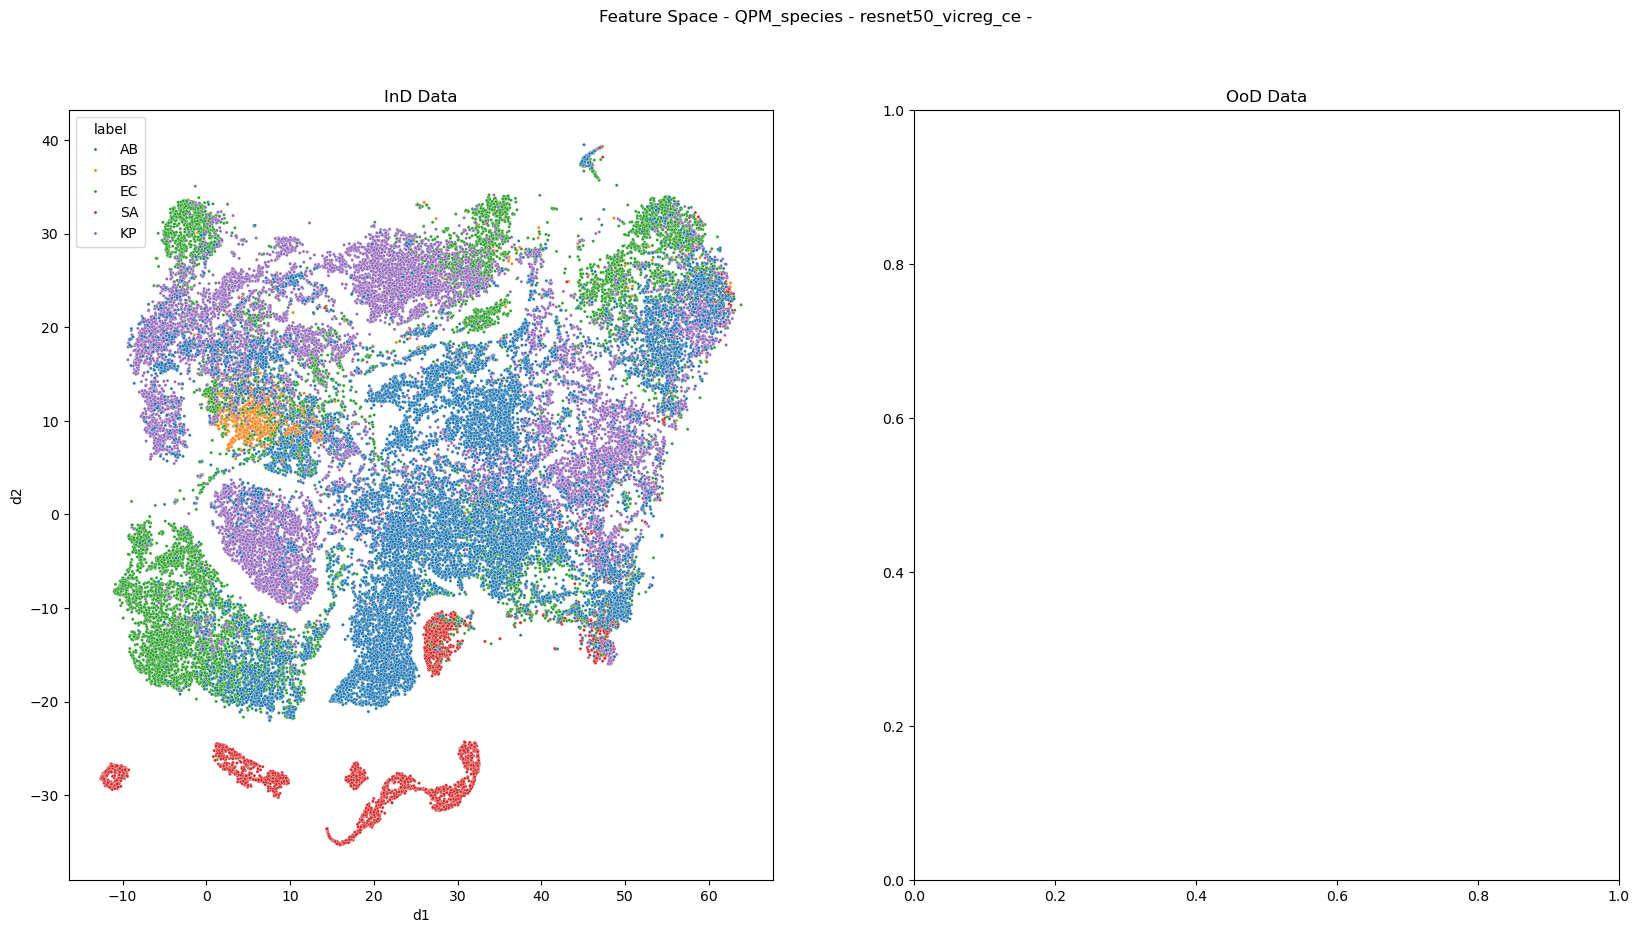

In [12]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

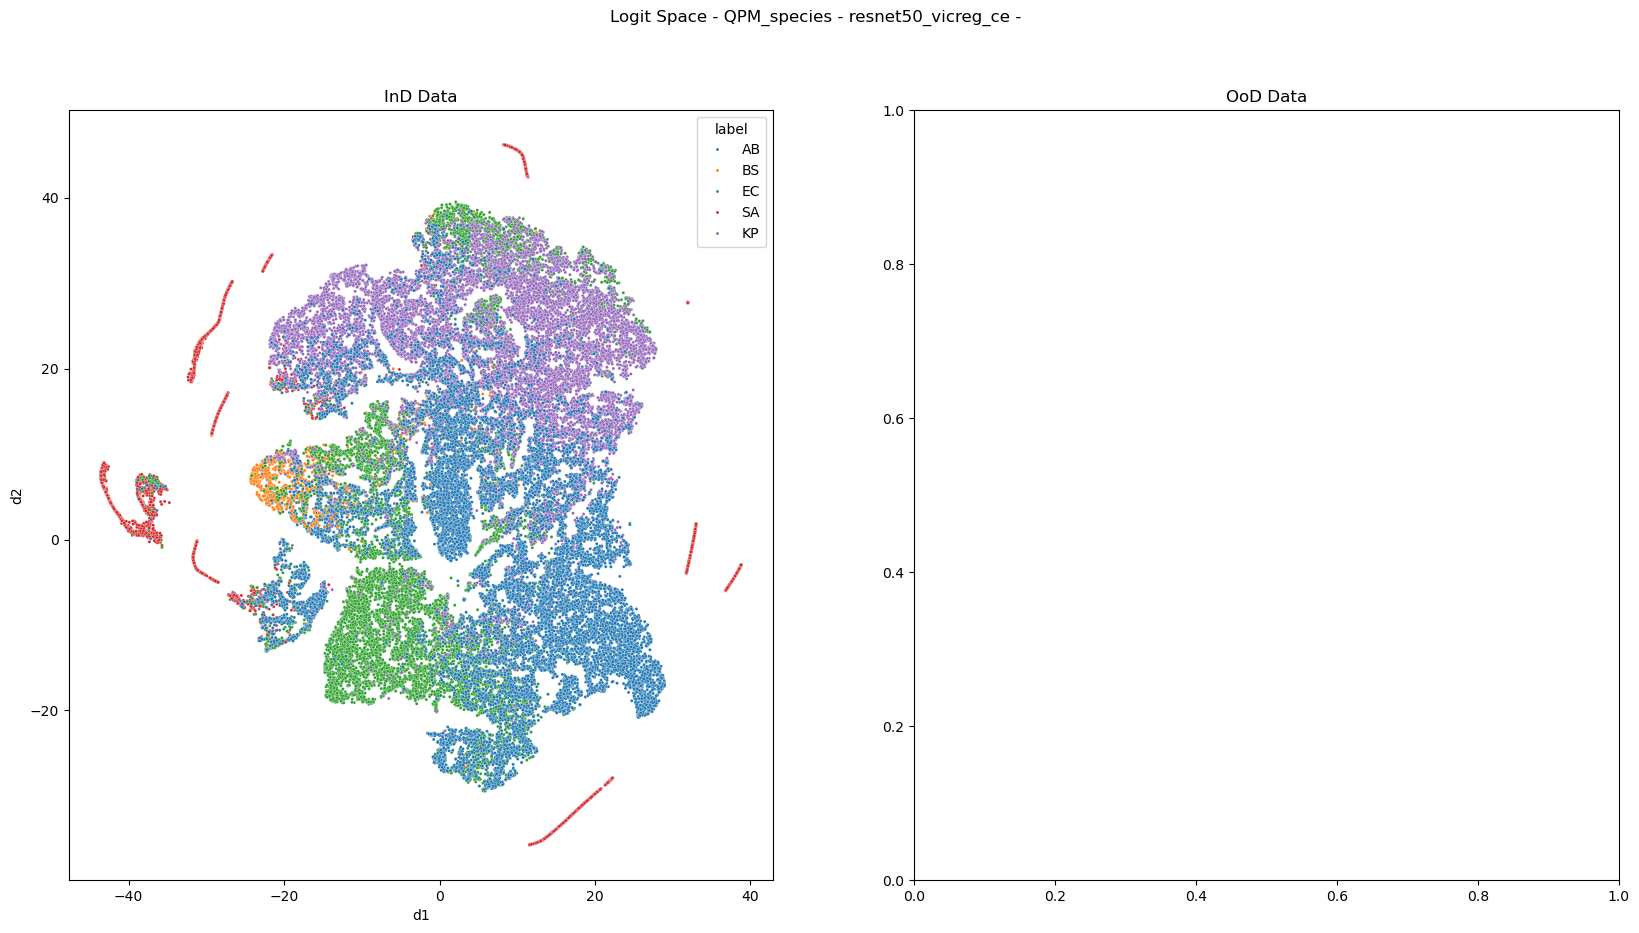

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [01:00<03:01, 60.43s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [02:00<02:01, 60.51s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [03:01<01:00, 60.68s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:03<00:00, 60.93s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:03<00:00, 60.80s/it]

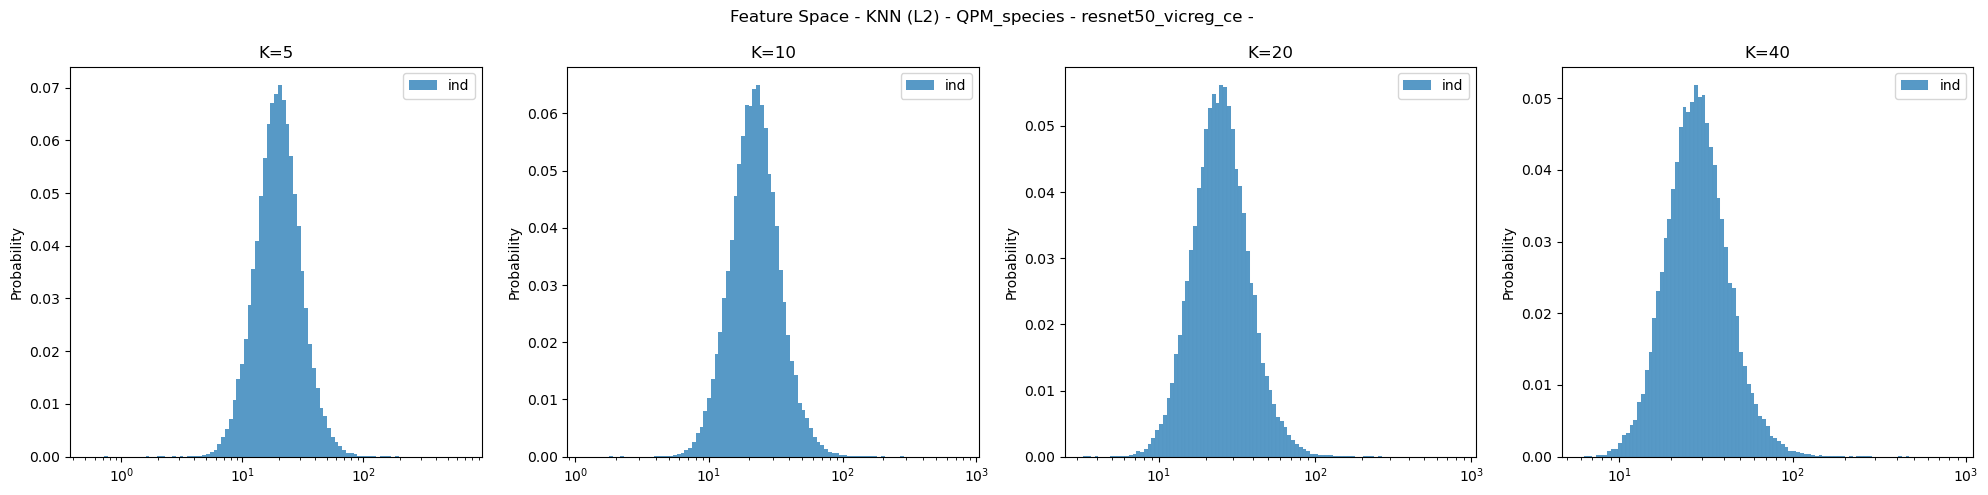

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [01:00<03:00, 60.28s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [02:00<02:00, 60.34s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [03:01<01:00, 60.45s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:02<00:00, 60.68s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:02<00:00, 60.57s/it]

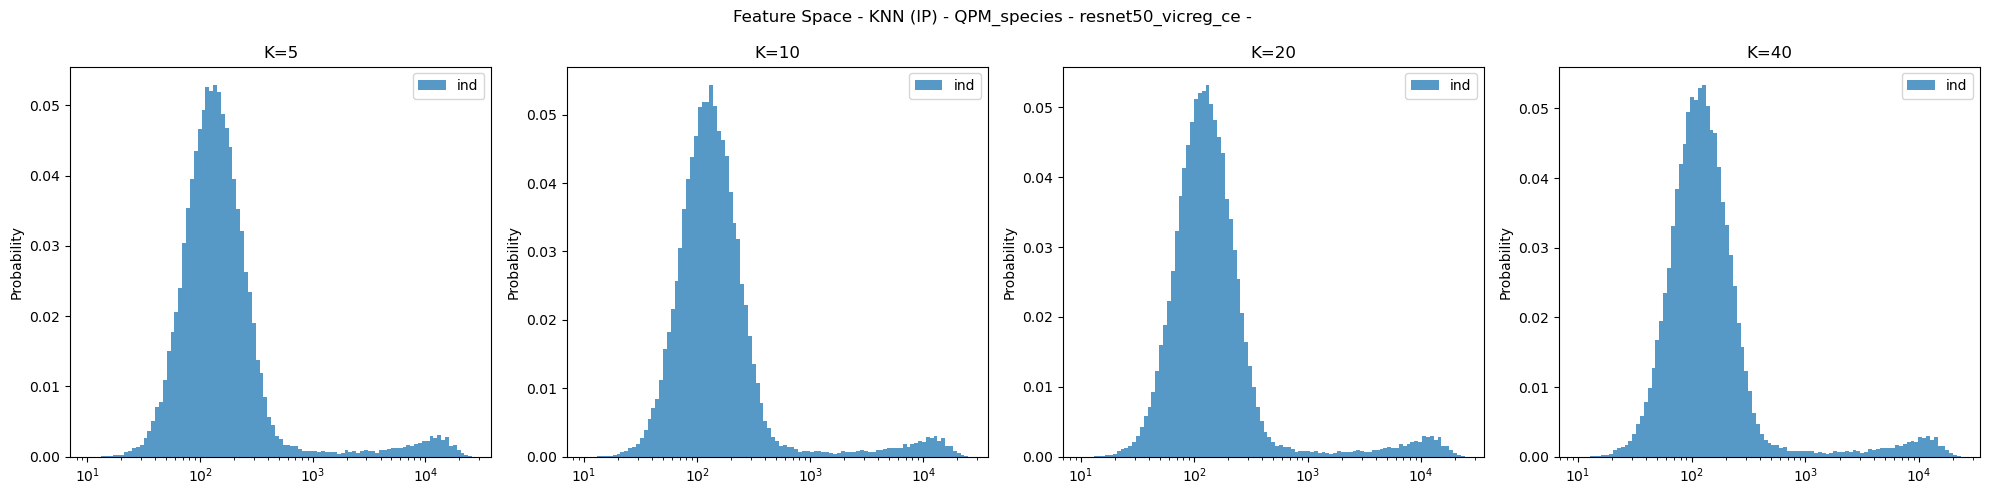

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:02<00:06,  2.27s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:04<00:04,  2.31s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:07<00:02,  2.40s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.59s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.50s/it]

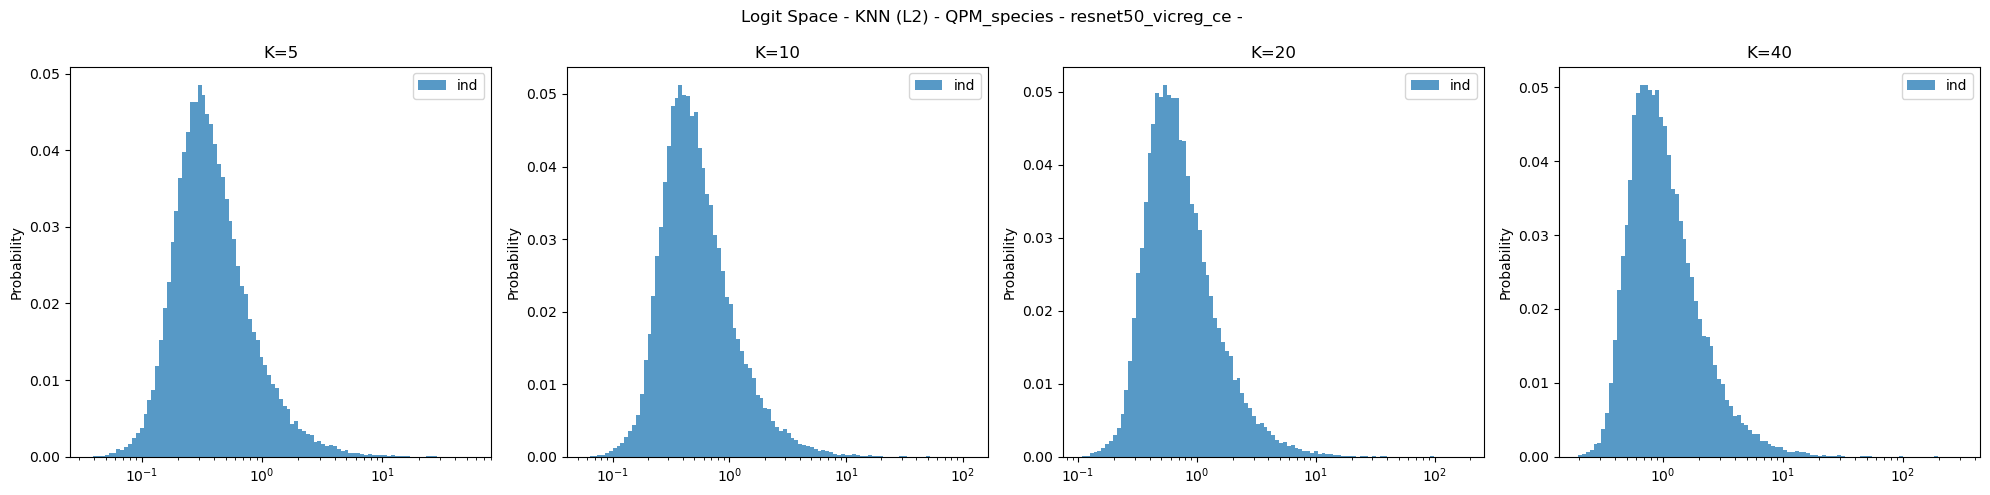

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:05,  1.95s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:03<00:04,  2.00s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:06<00:02,  2.12s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.32s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.22s/it]

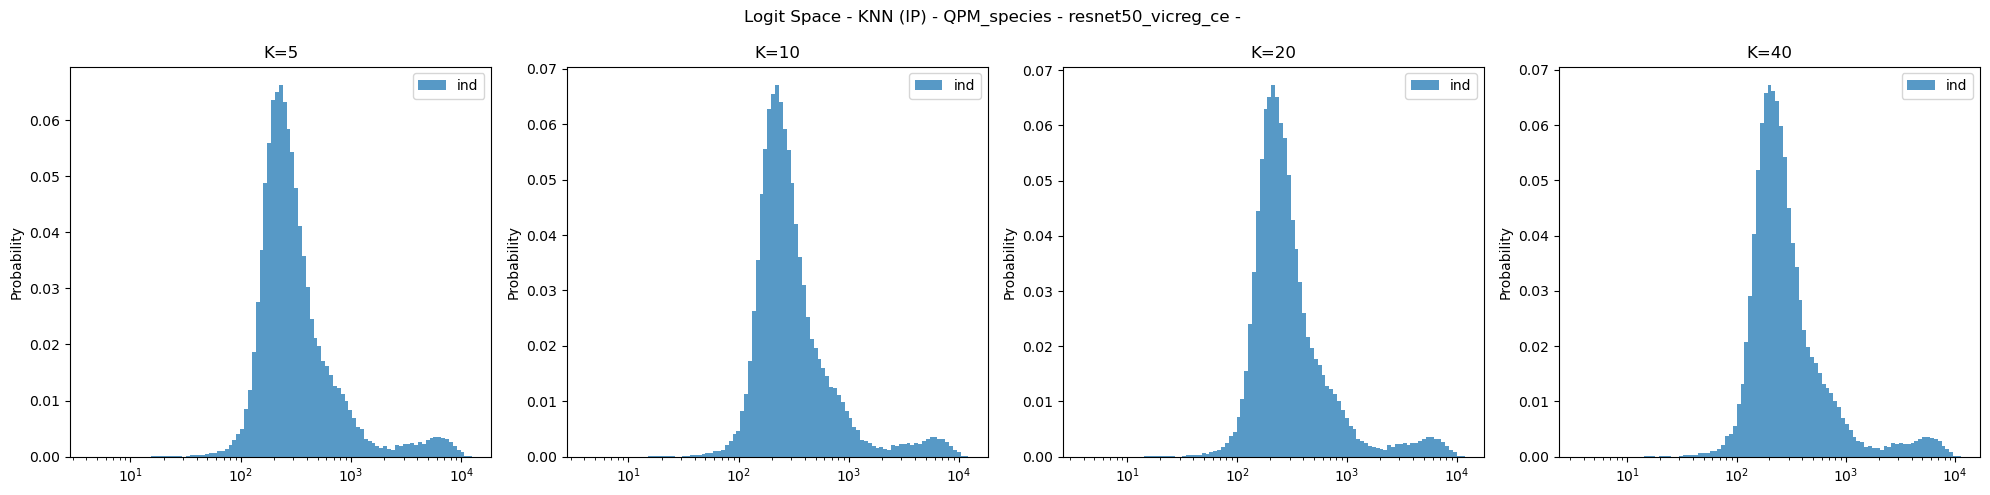

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

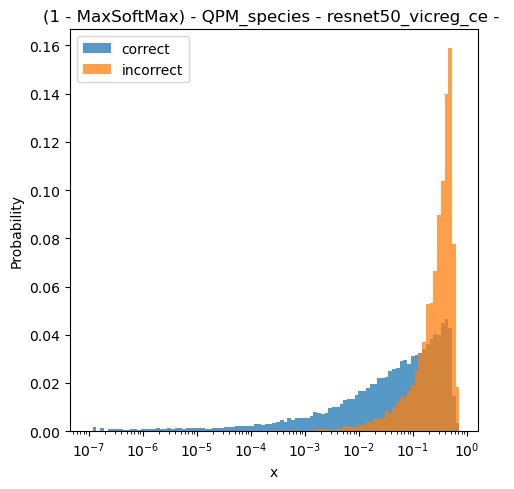

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()